In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

from xgboost import XGBRegressor

import pickle

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = r"D:\Projects\Mini_Projects\Clickstream_customer_conversion\Research_Data\processed_data.csv"

In [3]:
data = pd.read_csv(file_path)

In [4]:
data.head()

,month,day,country,page1_main_category,colour,location,model_photography,page,avg_price,unique_products,browsing_depth,weekend,high_price_preference
0,6,22,29,3,13,1,2,2,46.928571,55,4,1,1
1,5,19,29,2,13,3,1,2,57.666667,4,2,0,1
2,7,15,29,3,9,5,1,1,38.900000,9,3,0,1
3,5,2,29,2,2,4,1,1,51.666667,5,2,0,0
4,6,9,29,2,9,5,1,2,52.333333,12,2,0,1


In [5]:
val = data.drop('avg_price', axis = 1)
tar = data['avg_price']

In [6]:
fs = XGBRegressor(n_estimators = 200, random_state = 65)

In [7]:
fs.fit(val, tar)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=65, ...)

In [8]:
selected = pd.DataFrame({
    "col": val.columns,
    'sco':fs.feature_importances_
}).sort_values('sco', ascending = False).head(9)['col'].to_list()

In [9]:
selected

['high_price_preference',
 'page1_main_category',
 'browsing_depth',
 'unique_products',
 'model_photography',
 'colour',
 'location',
 'page',
 'country']

In [10]:
val = val[selected]

tar = tar

In [11]:
val[selected]

,high_price_preference,page1_main_category,browsing_depth,unique_products,model_photography,colour,location,page,country
0,1,3,4,55,2,13,1,2,29
1,1,2,2,4,1,13,3,2,29
2,1,3,3,9,1,9,5,1,29
3,0,2,2,5,1,2,4,1,29
4,1,2,2,12,1,9,5,2,29
...,...,...,...,...,...,...,...,...,...
132374,1,4,5,5,1,2,1,2,29
132375,0,3,5,31,1,14,3,2,29
132376,0,1,1,8,2,3,2,1,29
132377,0,3,4,18,2,9,5,3,29


In [12]:
x_train, x_test, tr_lab, ts_lab = train_test_split(val, tar, test_size = 0.2, random_state = 65)

In [23]:
scaler = StandardScaler()

In [22]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Linear Regression

In [21]:
def build_linear_regression(x_train, x_test, tr_lab, ts_lab):

    print('\n----------Building Linear Regression----------')

    lr = LinearRegression()

    lr.fit(x_train, tr_lab)

    ts_pred = lr.predict(x_test)

    rmse = root_mean_squared_error(ts_lab, ts_pred)
    mse = mean_squared_error(ts_lab, ts_pred)
    mae = mean_absolute_error(ts_lab, ts_pred)
    r2 = r2_score(ts_lab, ts_pred)

    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

    return lr

# Ridge Regression

In [20]:
def build_ridge_regression(x_train, x_test, tr_lab, ts_lab):

    print('\n----------Building Ridge Regression----------')

    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'max_iter': [1000, 2000]
    }

    ridge = Ridge(random_state = 65)

    random_search = RandomizedSearchCV(
        ridge,
        param_grid,
        n_iter = 20,
        cv = 3,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1,
        verbose = 1
    )

    random_search.fit(x_train, tr_lab)

    best_model = random_search.best_estimator_

    ts_pred = best_model.predict(x_test)

    rmse = root_mean_squared_error(ts_lab, ts_pred)
    mse = mean_squared_error(ts_lab, ts_pred)
    mae = mean_absolute_error(ts_lab, ts_pred)
    r2 = r2_score(ts_lab, ts_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score (neg MSE): {random_search.best_score_:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

    return best_model

# Lasso Regression

In [ ]:
def build_lasso_regression(x_train, x_test, tr_lab, ts_lab):

    print('\n----------Building Lasso Regression----------')

    param_grid = {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
        'max_iter': [1000, 2000]
    }

    lasso = Lasso(random_state = 65)

    random_search = RandomizedSearchCV(
        lasso,
        param_grid,
        n_iter = 20,
        cv = 3,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1,
        verbose = 1
    )

    random_search.fit(x_train, tr_lab)

    best_model = random_search.best_estimator_

    ts_pred = best_model.predict(x_test)

    rmse = root_mean_squared_error(ts_lab, ts_pred)
    mse = mean_squared_error(ts_lab, ts_pred)
    mae = mean_absolute_error(ts_lab, ts_pred)
    r2 = r2_score(ts_lab, ts_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score (neg MSE): {random_search.best_score_:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

    return best_model

# Gradient Boosting

In [19]:
def build_gradient_boosting_regressor(x_train, x_test, tr_lab, ts_lab):

    print('\n----------Building Gradient Boosting Regression----------')

    param_grid = {
        'n_estimators': [100, 200, 300],  
        'learning_rate': [0.01, 0.05, 0.1, 0.2],  
        'max_depth': [3, 5, 7, 10],  
        'subsample': [0.7, 0.8, 1.0],  
        'min_samples_split': [2, 5, 10],  
        'min_samples_leaf': [1, 2, 4]  
    }

    gbr = GradientBoostingRegressor(random_state=65, warm_start = True)

    random_search = RandomizedSearchCV(
        gbr,
        param_grid,
        n_iter = 20,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(x_train, tr_lab)

    best_model = random_search.best_estimator_

    ts_pred = best_model.predict(x_test)

    rmse = root_mean_squared_error(ts_lab, ts_pred)
    mse = mean_squared_error(ts_lab, ts_pred)
    mae = mean_absolute_error(ts_lab, ts_pred)
    r2 = r2_score(ts_lab, ts_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score (neg MSE): {random_search.best_score_:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

    return best_model

# Comparing Models

In [24]:
def compare_models(models_dict, x_test, ts_lab):

    print('\n----------Comparing Models---------')

    results = {}

    for name, model in models_dict.items():
        
        ts_pred = model.predict(x_test)

        rmse = root_mean_squared_error(ts_lab, ts_pred)
        mse = mean_squared_error(ts_lab, ts_pred)
        mae = mean_absolute_error(ts_lab, ts_pred)
        r2 = r2_score(ts_lab, ts_pred)

        results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'Predictions': ts_pred
        }

        comparison = pd.DataFrame({
        model_name: {
            'MSE': result['MSE'],
            'RMSE': result['RMSE'],
            'MAE': result['MAE'],
            'R2': result['R2']
        }
        for model_name, result in results.items()
    }).T
        
    comparison = comparison.sort_values('R2', ascending=False)    

    print(comparison)

    best_model_name = comparison.index[0]

    best_model = models_dict[best_model_name]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))    

    sns.barplot(ax=axes[0], x=comparison.index, y='R2', data=comparison, palette='viridis')
    axes[0].set_title('Model R2 Score Comparison')
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('R2 Score')
    axes[0].tick_params(axis='x', rotation=45)
    
    sns.barplot(ax=axes[1], x=comparison.index, y='RMSE', data=comparison, palette='magma')
    axes[1].set_title('Model RMSE Comparison')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('RMSE')
    axes[1].tick_params(axis='x', rotation=45)
    
    fig.show()

    return comparison, results, best_model, best_model_name

# Final Call

In [27]:
def run_all_models(x_train, x_test, tr_lab, ts_lab):

    lr = build_linear_regression(x_train, x_test, tr_lab, ts_lab)
    ridge = build_ridge_regression(x_train, x_test, tr_lab, ts_lab)
    lasso = build_lasso_regression(x_train, x_test, tr_lab, ts_lab)
    gbr = build_gradient_boosting_regressor(x_train, x_test, tr_lab, ts_lab)

    models = {
        'Linear Regression': lr,
        'Ridge Regression': ridge,
        'Lasso Regression': lasso,
        'Gradient Boosting Regression': gbr
    }

    comparison, results, best_model, best_model_name = compare_models(models, x_test, ts_lab)

    pickle_path = r'D:\Projects\Mini_Projects\Clickstream_customer_conversion\Pickles'

    os.makedirs(pickle_path, exist_ok=True)

    best_model_reg = os.path.join(pickle_path, 'best_model_reg.pkl')

    with open(best_model_reg, 'wb') as file:
        pickle.dump(best_model, file)

    print(f"\nBest Model for Regression: {best_model_name} saved to 'best_model_reg.pkl'")

    return models, comparison, results, best_model, best_model_name


----------Building Linear Regression----------
MSE: 28.7490
RMSE: 5.3618
MAE: 4.0943
R2 Score: 0.2547

----------Building Ridge Regression----------
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_iter': 1000, 'alpha': 10.0}
Best Cross-Validation Score (neg MSE): -28.3396
MSE: 28.7491
RMSE: 5.3618
MAE: 4.0943
R2 Score: 0.2547

----------Building Lasso Regression----------
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_iter': 1000, 'alpha': 0.0001}
Best Cross-Validation Score (neg MSE): -28.3396
MSE: 28.7491
RMSE: 5.3618
MAE: 4.0943
R2 Score: 0.2547

----------Building Gradient Boosting Regression----------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 7, 'learning_rate': 0.1}
Best Cross-Validation Score (neg MSE): -17.6765
MSE: 17.6783
RMSE: 4.2046
MAE: 3.1754
R2 Score: 0.5417

-----

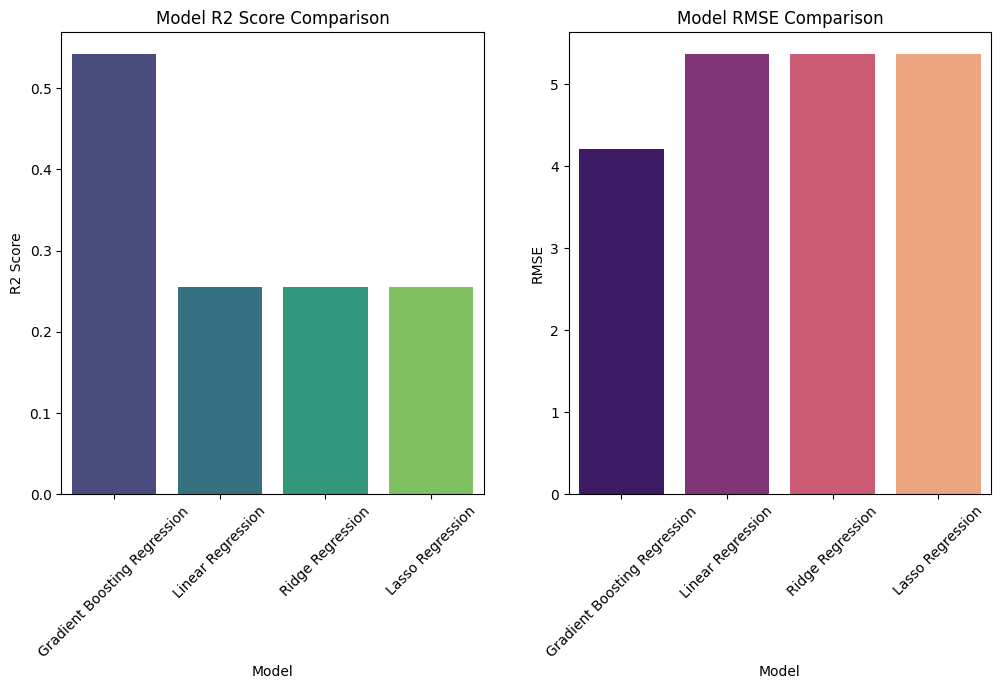

In [28]:
models, comparison, results, best_model, best_model_name = run_all_models(x_train, x_test, tr_lab, ts_lab)